## Principal Component Analysis

Principal Component Analysis (PCA) allows you do to fundamentally break down your dataset into principal components which collectively explain the varience in your dataset. It's a popular dimesionality reduction technique because you can control how much you want to reconstruct the data. For example, images can be recreated with only a couple of principal components, allowing high accuracy and saved space. The technique uses orthogonal eigenvectors that independently record their own information, eliminating redundancy and double counting.

The technique is powered by performing singular value decomposition (SVD) onto a matrix transformation. SVD essentially decomposes any matrix into 3 simpler transformations (A = UΣVᵀ), where U and Vᵀ are orthornomal matrices containing eigenvectors and Σ is a diagonal matrix. SVD is awesome because you can break down any complex matrix transformation and gain a geometric intrepretation of it. The decomposition begins by rotating the right singular vectors (Vᵀ), which are orthogonal eigen vectors, into alignment of the standard basis vectors. Then, Σ stretches/shrinks Vᵀ. Finally, the stretched vectors are rotated to align with the left singular vectors; note that the rotations can result in jumping to different dimensions. If you multiply these matrices sequentially, you will get back the A matrix.

In the case of PCA, we can use the vectors in Vᵀ to construct the 'skeleton' of the data and the scalars within Σ to 'embody' the data; to be more specific, the vectors within Vᵀ are the principal components and the square of the scalars within Σ are variances. Since these PCs capture their own unique information within their direction, you can take the ones with the most information (high variences) and leave out the remaining ones, i.e. choosing the top K principal components.

PCA produces loadings and scores. Loadings are the coefficients of the features within a PC. They can be interpreted as the contribution or importance of a feature in forming the PC. Scores are data points that are projected onto the PC. They can tell you how similar the data point is scored to the PC.

Lastly, PCA has 3 main problems:

    - Sensitivity to outliers and unscaled features
        -Fix: clean data of outliers, and standarize your dataset
    - Linear relationships
        -Fix: Use other PCA techniques that captures non-linear relationships
    - Subjective Intrepretation
        -Fix: use domain knowledge and loadings to intrepret PC

## PCA on an Image

In [260]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
import random

from sklearn.datasets import fetch_olivetti_faces


In [261]:
np.random.seed(42)
X = fetch_olivetti_faces(shuffle=True)
data, images = X["data"], X["images"]

print("Data Shape: ",data.shape)
print("Images shape: ",images.shape)

Data Shape:  (400, 4096)
Images shape:  (400, 64, 64)


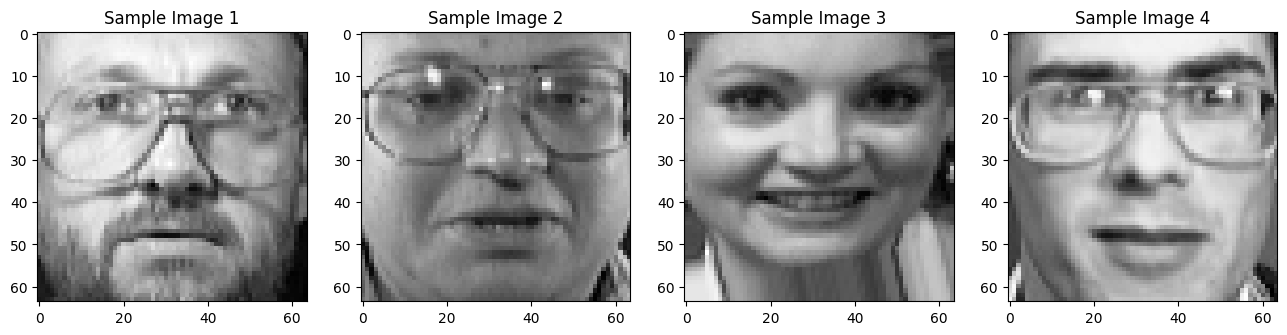

In [262]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))


for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap="gray")
    ax.set_title(f"Sample Image {i+1}")

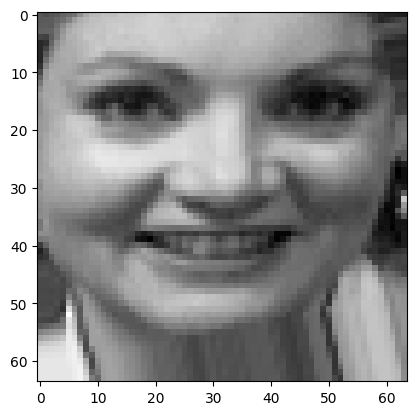

In [263]:
img = images[2]
plt.imshow(img, cmap="grey")

In [264]:
img

array([[0.37190083, 0.34710744, 0.3677686 , ..., 0.20247933, 0.1983471 ,
        0.19008264],
       [0.38016528, 0.38429752, 0.38842976, ..., 0.2768595 , 0.30578512,
        0.3264463 ],
       [0.38842976, 0.39256197, 0.38429752, ..., 0.37190083, 0.35950413,
        0.34710744],
       ...,
       [0.8305785 , 0.8305785 , 0.8305785 , ..., 0.6942149 , 0.6528926 ,
        0.5289256 ],
       [0.8305785 , 0.8305785 , 0.8305785 , ..., 0.6983471 , 0.677686  ,
        0.5413223 ],
       [0.8305785 , 0.8305785 , 0.8305785 , ..., 0.7066116 , 0.6818182 ,
        0.5495868 ]], dtype=float32)

In [265]:
img_norm = img - img.mean(axis=0)

In [266]:
U, D, V_t = np.linalg.svd(img_norm)

In [267]:

variences = D**2 / (D.shape[0] - 1)
pcs = V_t.T[:,:]
print("PCS shape: ",pcs.shape)

top_k_pcs = pd.Series(np.round(variences/variences.sum()*100, 3)[:10], index=np.arange(1, 11))
top_k_pcs.name = f"Explained VA % for top {10} Principal Components"
top_k_pcs

PCS shape:  (64, 64)


1     48.855999
2     18.834999
3     11.445000
4      8.619000
5      2.811000
6      2.369000
7      1.423000
8      1.125000
9      0.947000
10     0.640000
Name: Explained VA % for top 10 Principal Components, dtype: float32

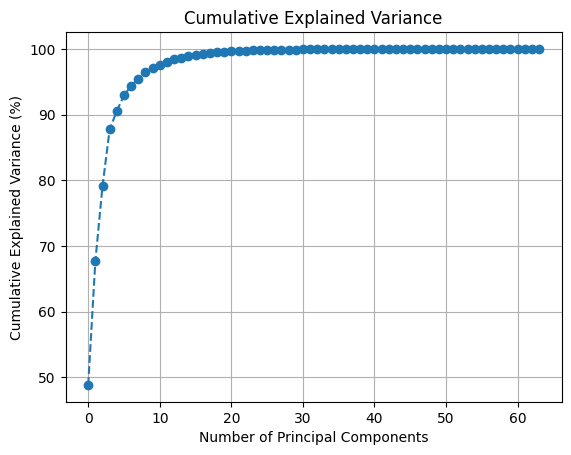

In [268]:
plt.plot(np.cumsum(variences/variences.sum()*100), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)

Image norm shape:  (64, 64)
Rows scores shape:  (64, 10)
Best PC shape:  (64, 10)
MSE for top 10 PCs:  0.0006778124


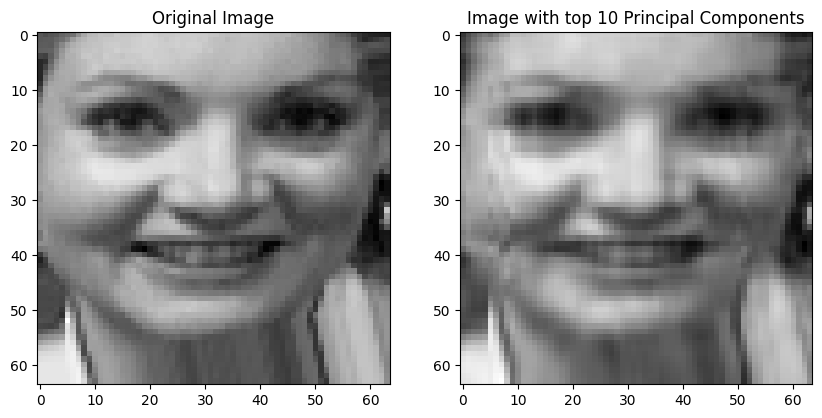

In [277]:
k = 10
best_pc = pcs[:,:k]



rows_scores = img_norm @ best_pc
img_norm_scored = rows_scores @ best_pc.T
img_rescaled = img_norm_scored + img.mean(axis=0)
img_rescaled = np.clip(img_rescaled, 0, 1)

print("Image norm shape: ",img_norm_scored.shape)
print("Rows scores shape: ",rows_scores.shape)
print("Best PC shape: ",best_pc.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap="grey")
ax[0].set_title("Original Image")
ax[1].imshow(img_rescaled, cmap="grey")
ax[1].set_title(f"Image with top {k} Principal Components")
print(f"MSE for top {k} PCs: ",np.mean((img - img_rescaled)**2))


In [270]:
def PCA(image, k=10):

    best_pc = pcs[:,:k]

    img_norm = image - image.mean(axis=0)

    rows_scores = img_norm @ best_pc
    img_norm_scored = rows_scores @ best_pc.T
    img_rescaled = img_norm_scored + img.mean(axis=0)
    img_rescaled = np.clip(img_rescaled, 0, 1)

    return img_rescaled

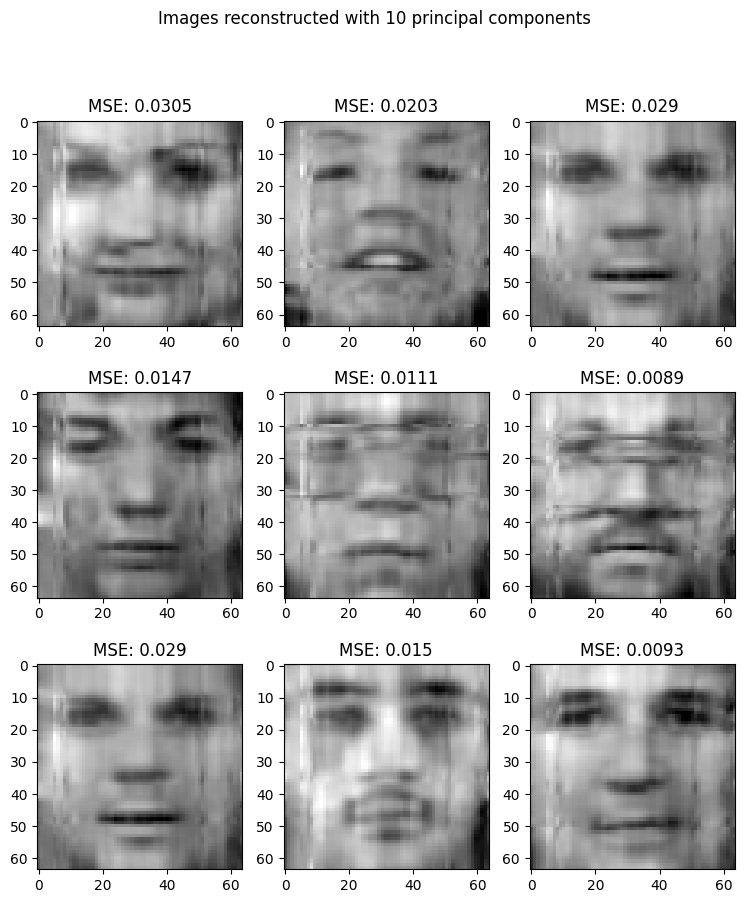

In [281]:
fig, ax = plt.subplots(3, 3, figsize=(9, 10))

k = 10

fig.suptitle(f"Images reconstructed with {k} principal components")

for ax_i in ax:

    for ax_j in ax_i:

        image = images[np.random.randint(0, 40)]

        pca_image = PCA(image, k=k)
        
        mse = np.mean((image - pca_image)**2)
        mse = round(mse, 4)

        ax_j.imshow(pca_image, cmap="grey")
        ax_j.set_title(f"MSE: {str(mse)}")
